# Importign required modules

In [14]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [15]:
# Train transformations
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
  ])

# Test transformations
test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
  ])


In [16]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [18]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

SEED = 1
# To reproduce the same results across the sessions
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)
  dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
else:
  dataloader_args = dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Stats
Calculating the mean and standard deviation of the data.

Just for understanding the data.

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train data]
 - Numpy Shape: (28, 60000, 28)
 - Tensor Shape: torch.Size([28, 60000, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


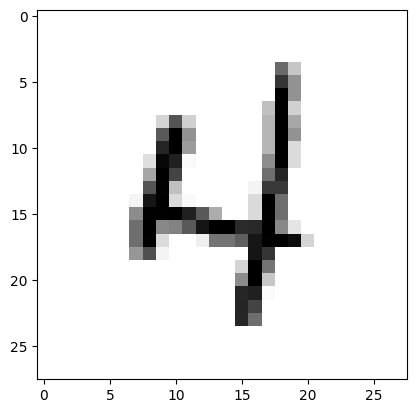

In [20]:
# Convert back tensors back to Numpy
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train data]')
print(' - Numpy Shape:', train_data.numpy().shape)
print(' - Tensor Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

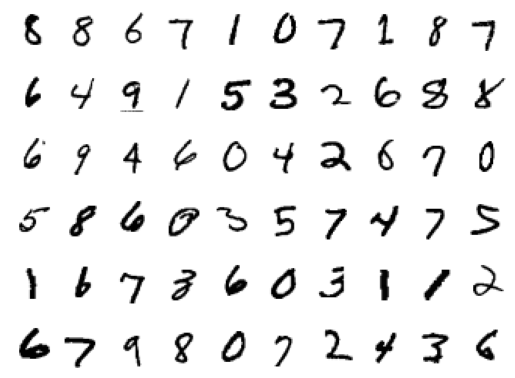

In [21]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Data Stats2
The previous block provided statistics for a normalized dataset, resulting in a mean of zero and a standard deviation of one. In this block, we obtain the mean and standard deviation for the raw, unnormalized data.

This step is not necessary if we already have prior knowledge of the mean and standard deviation of the dataset

In [22]:
# simple transform
simple_transforms = transforms.Compose([transforms.ToTensor(),])

exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp_data.numpy().shape)
print(' - Tensor Shape:', exp_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (28, 60000, 28)
 - Tensor Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# Model

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11


        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7


        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1 7x7x10 | 7x7x10x10 | 1x1x10

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [25]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,432
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,728
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           4,096
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 64, 9, 9]          18,432
             ReLU-11             [-1, 64, 9, 9]               0
           Conv2d-12            [-1, 128, 7, 7]          73,728
             ReLU-13            [-1, 128, 7, 7]               0
           Conv2d-14             [-1, 1

In [26]:
from tqdm import tqdm

# Aggregate loss and accuracy
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get batch data
    data, target = data.to(device), target.to(device)

    # Reset all gradients to zero
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Do calculate the grads in dackpropagation
    loss.backward()

    # Update the model weights
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Aggregate batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Update total test data loss
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Training & Testing

In [28]:
# Creat the mode and move it to CUDA
model = Net().to(device)

# Using stochastic gradient descent method for optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.14870892465114594 Batch_id=468 Accuracy=72.12: 100%|██████████| 469/469 [00:18<00:00, 24.71it/s]



Test set: Average loss: 0.1570, Accuracy: 9530/10000 (95.30%)

EPOCH: 1


Loss=0.08245093375444412 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:18<00:00, 26.00it/s]



Test set: Average loss: 0.0706, Accuracy: 9757/10000 (97.57%)

EPOCH: 2


Loss=0.16400326788425446 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:19<00:00, 24.17it/s]



Test set: Average loss: 0.0562, Accuracy: 9814/10000 (98.14%)

EPOCH: 3


Loss=0.08568193763494492 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:18<00:00, 25.23it/s]



Test set: Average loss: 0.0517, Accuracy: 9827/10000 (98.27%)

EPOCH: 4


Loss=0.09290111064910889 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]



Test set: Average loss: 0.0521, Accuracy: 9823/10000 (98.23%)

EPOCH: 5


Loss=0.05602209270000458 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s]



Test set: Average loss: 0.0555, Accuracy: 9830/10000 (98.30%)

EPOCH: 6


Loss=0.007020541001111269 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]



Test set: Average loss: 0.0417, Accuracy: 9861/10000 (98.61%)

EPOCH: 7


Loss=0.041605912148952484 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]



Test set: Average loss: 0.0373, Accuracy: 9881/10000 (98.81%)

EPOCH: 8


Loss=0.010604005306959152 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]



Test set: Average loss: 0.0407, Accuracy: 9867/10000 (98.67%)

EPOCH: 9


Loss=0.008707546629011631 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:19<00:00, 24.11it/s]



Test set: Average loss: 0.0393, Accuracy: 9855/10000 (98.55%)

EPOCH: 10


Loss=0.01651078648865223 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s]



Test set: Average loss: 0.0376, Accuracy: 9876/10000 (98.76%)

EPOCH: 11


Loss=0.03365078195929527 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:19<00:00, 24.15it/s]



Test set: Average loss: 0.0388, Accuracy: 9868/10000 (98.68%)

EPOCH: 12


Loss=0.022974148392677307 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:19<00:00, 23.88it/s]



Test set: Average loss: 0.0354, Accuracy: 9880/10000 (98.80%)

EPOCH: 13


Loss=0.0037561471108347178 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]



Test set: Average loss: 0.0403, Accuracy: 9879/10000 (98.79%)

EPOCH: 14


Loss=0.009951502084732056 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:18<00:00, 25.07it/s]



Test set: Average loss: 0.0398, Accuracy: 9878/10000 (98.78%)



# Plot the Results

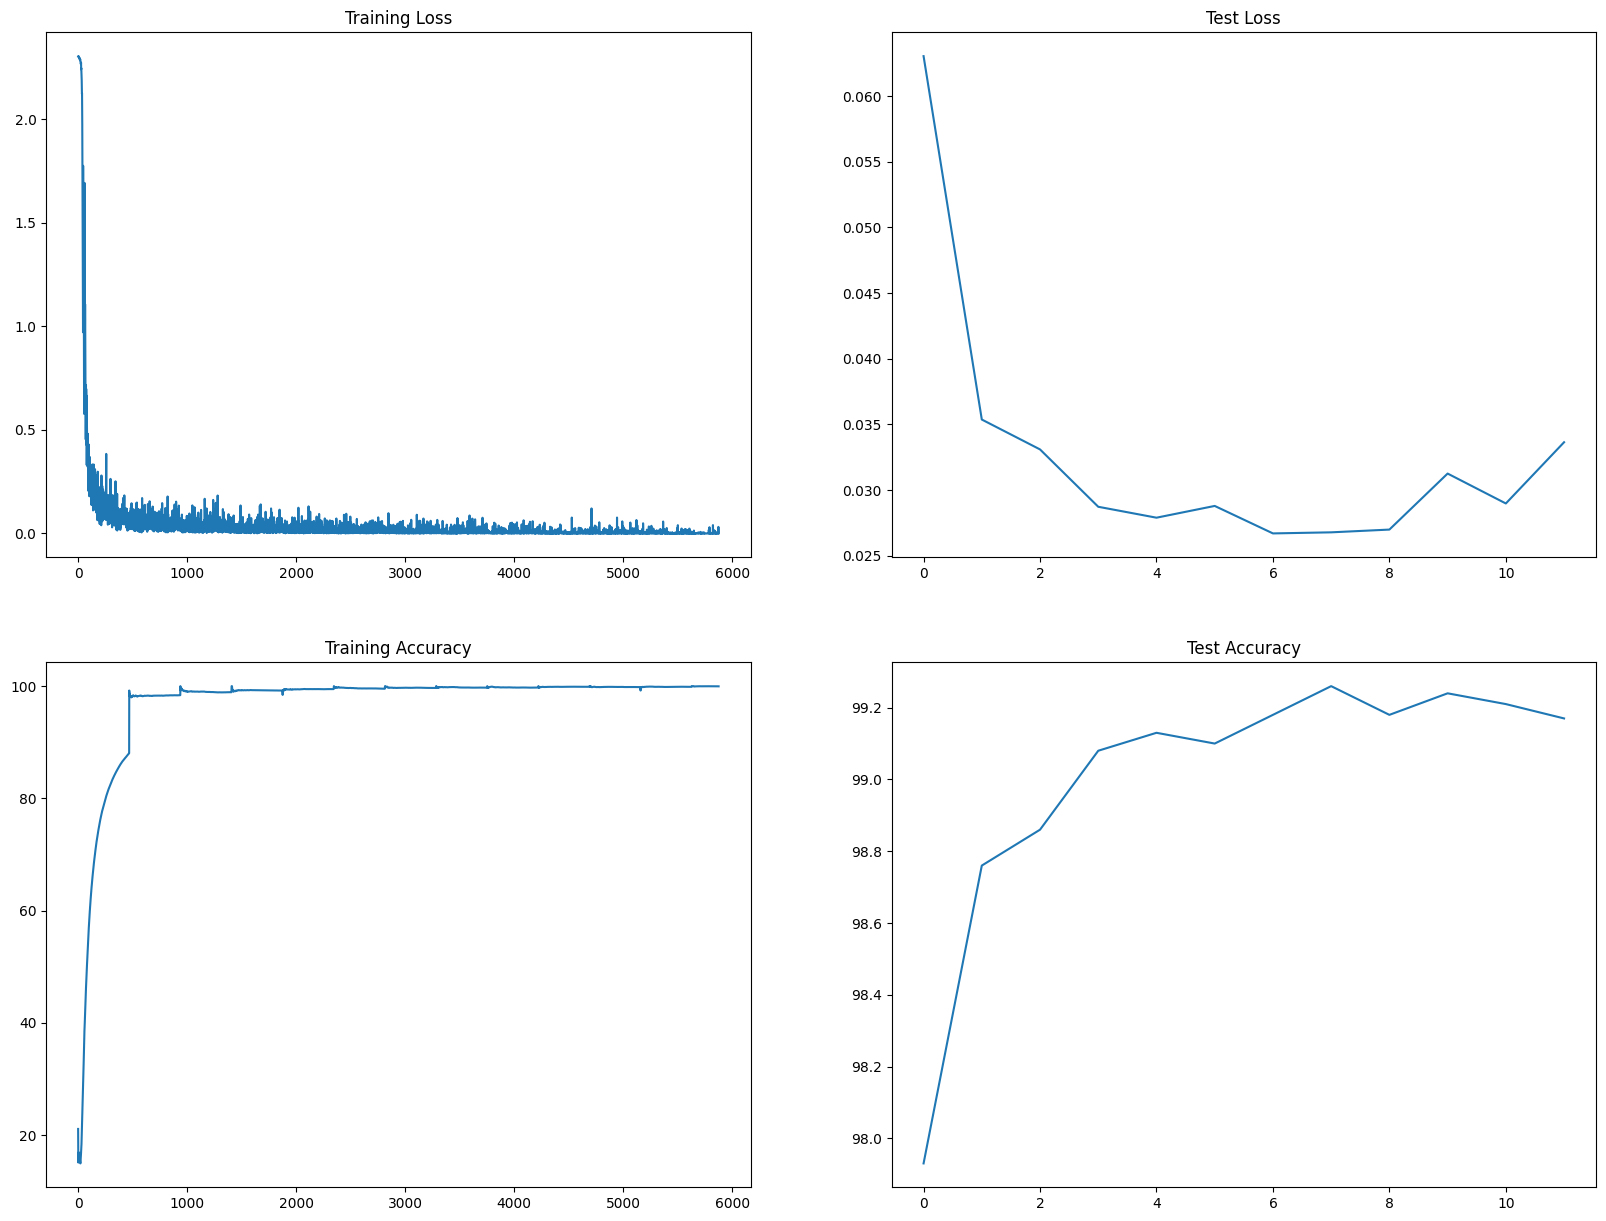

In [12]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(20,15))

axs[0, 0].set_title("Training Loss")
axs[0, 0].plot(t)

axs[1, 0].set_title("Training Accuracy")
axs[1, 0].plot(train_acc)

axs[0, 1].set_title("Test Loss")
axs[0, 1].plot(test_losses)

axs[1, 1].set_title("Test Accuracy")
axs[1, 1].plot(test_acc)

# Iteration 2
---
##Target:
*   Finding a right basic skeleton and committing to it

##Results:
*   Total params: 194,884
*   Best Training Accuracy: 99.36%
*   Best Test Accuracy: 98.80%

##Analysis:
*   Stopped running the after the 15th epoch as the train and test accuracy are not going to improve any further.
*   Although it is lighter compared to the previous one, it is still far away from the targeted number of parameters of 20K.
*   However, it still shows some signs of overfitting.